# Convolutional Neural Networks - Build Model
---
In this notebook, we build and train a **CNN** to classify images from the CIFAR-10 database. 
* The code provided here are **almost** working. You are required to build up a CNN model and train it.
* Make sure you covered implementations of the **TODO**s in this notebook

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='cifar_data.png' width=50% height=50% />

### Optional: Use [CUDA](http://pytorch.org/docs/stable/cuda.html) if Available

Since these are color (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, but they utilize GPU's for effcient parallel computation.

In [2]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

train_on_mps = torch.backends.mps.is_available()
if not train_on_mps:
    print('MPS is not available.  Training on CPU ...')
else:
    print('MPS is available!  Training on GPU ...')

MPS is available!  Training on GPU ...


## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)
---
Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

### Visualize a Batch of Training Data

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

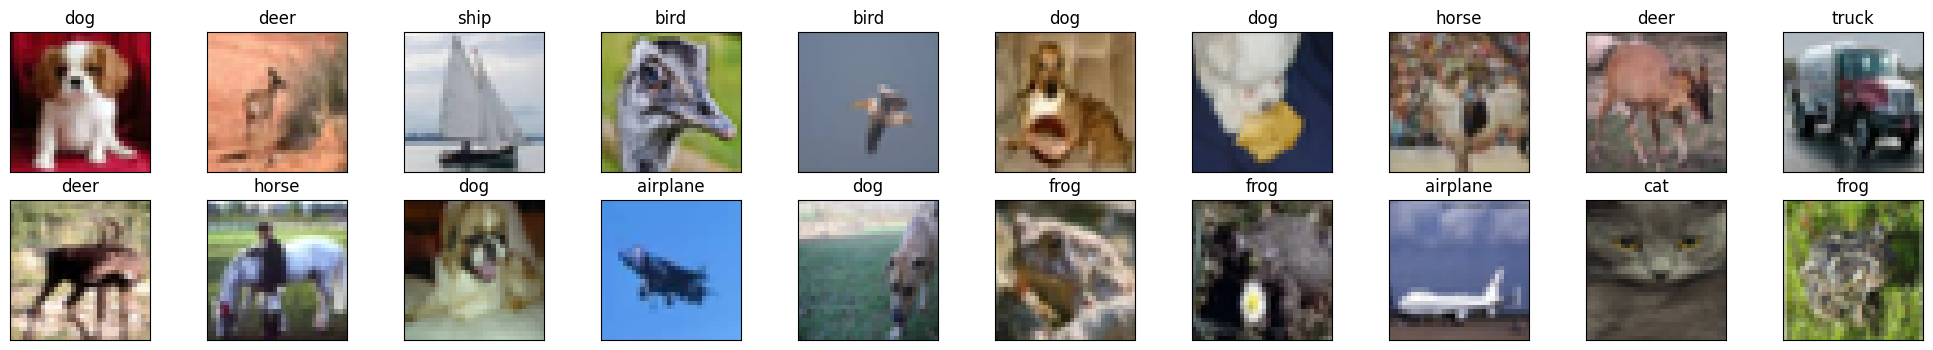

In [5]:
# obtain one batch of training images
dataiter = iter(train_loader)
#images, labels = dataiter.next() #python, torchvision version match issue
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

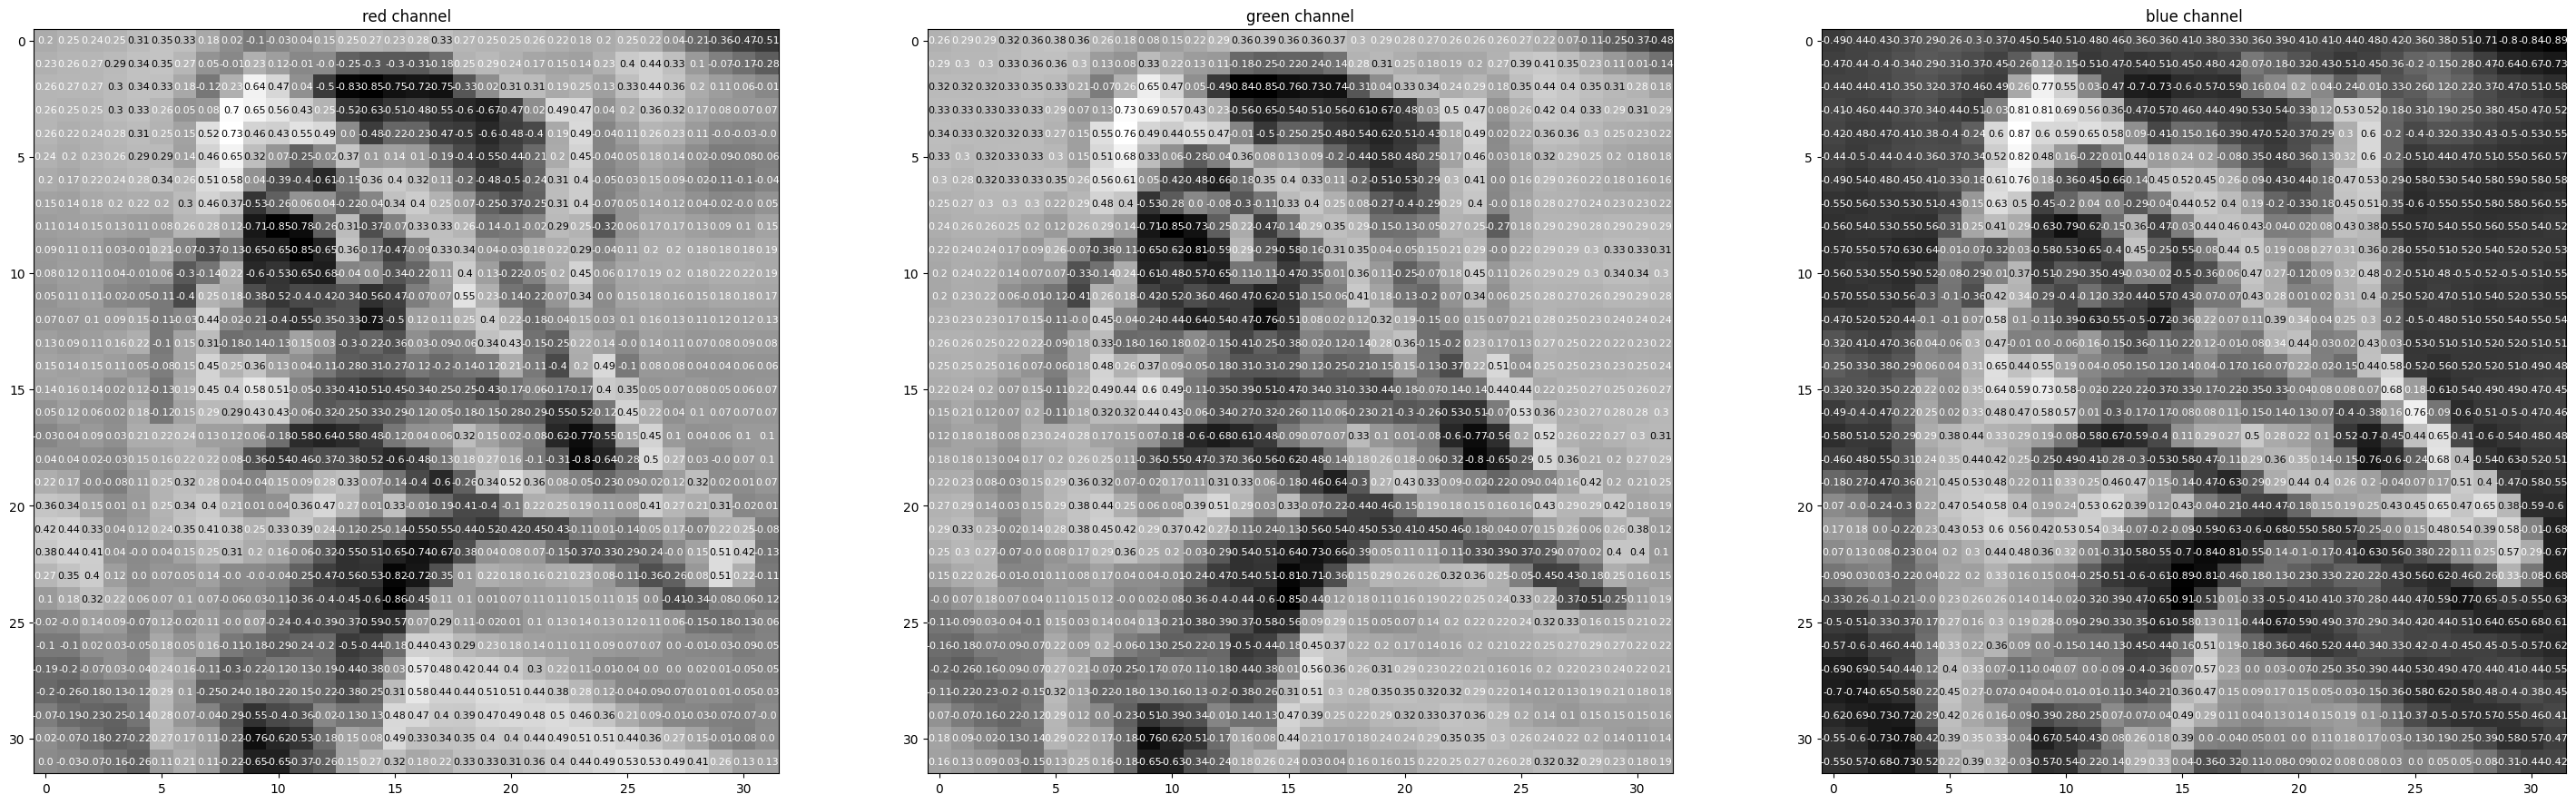

In [6]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## **TODO**: Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)
---
Build up your own Convolutional Neural Network using Pytorch API:
- nn.Conv2d(): for convolution
- nn.MaxPool2d(): for maxpooling (spatial resolution reduction)
- nn.Linear(): for last 1 or 2 layers of fully connected layer before the output layer.
- nn.Dropout(): optional, [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) can be used to avoid overfitting.
- F.relu(): Use ReLU as the activation function for all the hidden layers

The following is a skeleton example that's not completely working. 

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)
        
        # Adjust the fully connected layer input size based on the flattened output
        self.fc1 = nn.Linear(512 * 2 * 2, 4096)  # Corrected: 512 * 2 * 2 = 2048
        self.fc2 = nn.Linear(4096, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        # Flatten the output tensor
        x = x.view(-1, 512 * 2 * 2)  # Corrected flatten size: 512 * 2 * 2 = 2048
        
        x = self.dropout(F.relu(self.fc1(x)))  # Correct input size for fc1
        x = self.fc2(x)
        
        return x


# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_mps:
    model.to("mps")

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=2048, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=10, bias=True)
)


### MY ANALYSIS
The given Convolutional Neural Network (CNN) architecture demonstrates significant progress in terms of loss reduction and model improvement across 5 epochs. The model consists of four convolutional layers, each followed by ReLU activations, pooling, and dropout for regularization. The architecture effectively reduces overfitting by applying a dropout of 0.4 and using max pooling to reduce spatial dimensions, which helps prevent the model from memorizing the training data. The fully connected layers at the end help in classification, with the output layer producing a 10-class prediction.


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)
---
Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

The following is working code, but you can make your own adjustments.

**TODO**: try to compare with ADAM optimizer

In [15]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# TODO, compare with optimizer ADAM 
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

## Train the Network
---
Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

The following is working code, but you are encouraged to make your own adjustments and enhance the implementation.

Epoch: 1 	Training Loss: 1.645638 	Validation Loss: 0.345390
Validation loss decreased (inf → 0.345390). Saving model...
Epoch: 2 	Training Loss: 1.279573 	Validation Loss: 0.293982
Validation loss decreased (0.345390 → 0.293982). Saving model...
Epoch: 3 	Training Loss: 1.114394 	Validation Loss: 0.258582
Validation loss decreased (0.293982 → 0.258582). Saving model...
Epoch: 4 	Training Loss: 0.990456 	Validation Loss: 0.265248
Epoch: 5 	Training Loss: 0.876721 	Validation Loss: 0.211448
Validation loss decreased (0.258582 → 0.211448). Saving model...


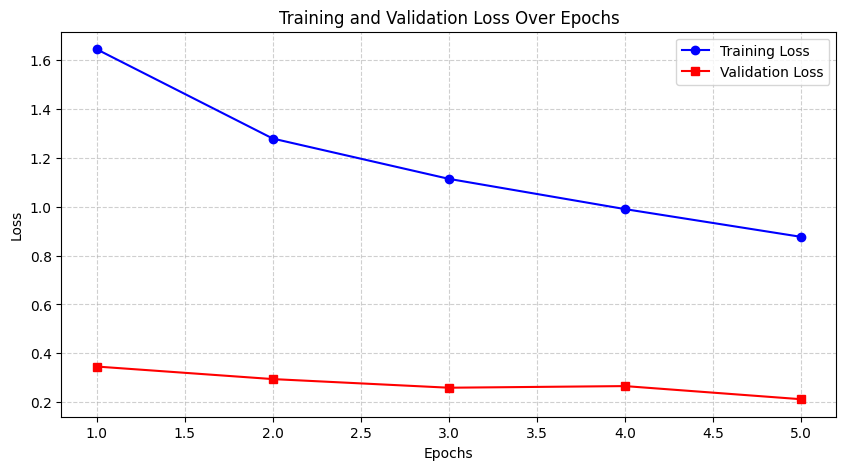

In [16]:
import matplotlib.pyplot as plt
# number of epochs to train the model, you decide the number
n_epochs = 5

# Arrays to store loss values
epochs_array = np.zeros(n_epochs)
training_losses_array = np.zeros(n_epochs)
validation_losses_array = np.zeros(n_epochs)

# Track minimum validation loss
valid_loss_min = np.inf  

# Check for available device (MPS for Mac or CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# Training Loop
for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training Phase
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to the correct device
        data, target = data.to(device), target.to(device)
        
        # Clear old gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Compute loss
        loss = criterion(output, target)
        
        # Backward pass & optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        train_loss += loss.item() * data.size(0)
        
    # Validation Phase
    model.eval()
    with torch.no_grad():  # No gradient calculation during validation
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
    
    # Compute average losses
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(valid_loader.dataset)

    # Store losses
    epochs_array[epoch - 1] = epoch
    training_losses_array[epoch - 1] = train_loss
    validation_losses_array[epoch - 1] = valid_loss
        
    # Print stats
    print(f"Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}")
    
    # Save model if validation loss improves
    if valid_loss <= valid_loss_min:
        print(f"Validation loss decreased ({valid_loss_min:.6f} → {valid_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), "model_trained.pt")
        valid_loss_min = valid_loss

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_array, training_losses_array, label="Training Loss", color="blue", marker="o")
plt.plot(epochs_array, validation_losses_array, label="Validation Loss", color="red", marker="s")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### MY ANALYSIS
The training process shows a steady decrease in both training and validation losses, indicating that the model is learning effectively from the data. The training loss gradually drops from 1.645638 in epoch 1 to 0.876721 by epoch 5, signaling that the model is converging. Similarly, the validation loss decreases from 0.345390 in epoch 1 to 0.211448 by the end of epoch 5, which reflects the model’s improved ability to generalize to unseen data.

###  Load the Model with the Lowest Validation Loss
This is the model we will use for testing, which is the model we saved in the last step

In [17]:
model.load_state_dict(torch.load('model_trained.pt'))

<All keys matched successfully>

## Test the Trained Network
---
Test your trained model on previously unseen data! Remember we have downloaded `train_data` and `test_data`. We will use `test_data` through `test_loader`.

A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

The following is working code, but you are encouraged to make your own adjustments and enhance the implementation.

In [18]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_mps:
        data, target = data.to("mps"), target.to("mps")
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_mps else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.042226

Test Accuracy of airplane: 65% (650/1000)
Test Accuracy of automobile: 78% (789/1000)
Test Accuracy of  bird: 50% (501/1000)
Test Accuracy of   cat: 45% (452/1000)
Test Accuracy of  deer: 36% (366/1000)
Test Accuracy of   dog: 61% (614/1000)
Test Accuracy of  frog: 76% (768/1000)
Test Accuracy of horse: 56% (567/1000)
Test Accuracy of  ship: 83% (837/1000)
Test Accuracy of truck: 74% (747/1000)

Test Accuracy (Overall): 62% (6291/10000)


### MY ANALYSIS
However, despite this improvement, the model’s test accuracy stands at 62%, suggesting that there may still be room for enhancement. This lower test accuracy could be attributed to several factors, such as insufficient model complexity, overfitting to the training set, or the need for further hyperparameter tuning Further experiments, including longer training times or different architectures, may help boost the performance of the model, especially in improving test accuracy and generalization.

### Visualize Sample Test Results

The following is working code, but you are encouraged to make your own adjustments and enhance the visualization.

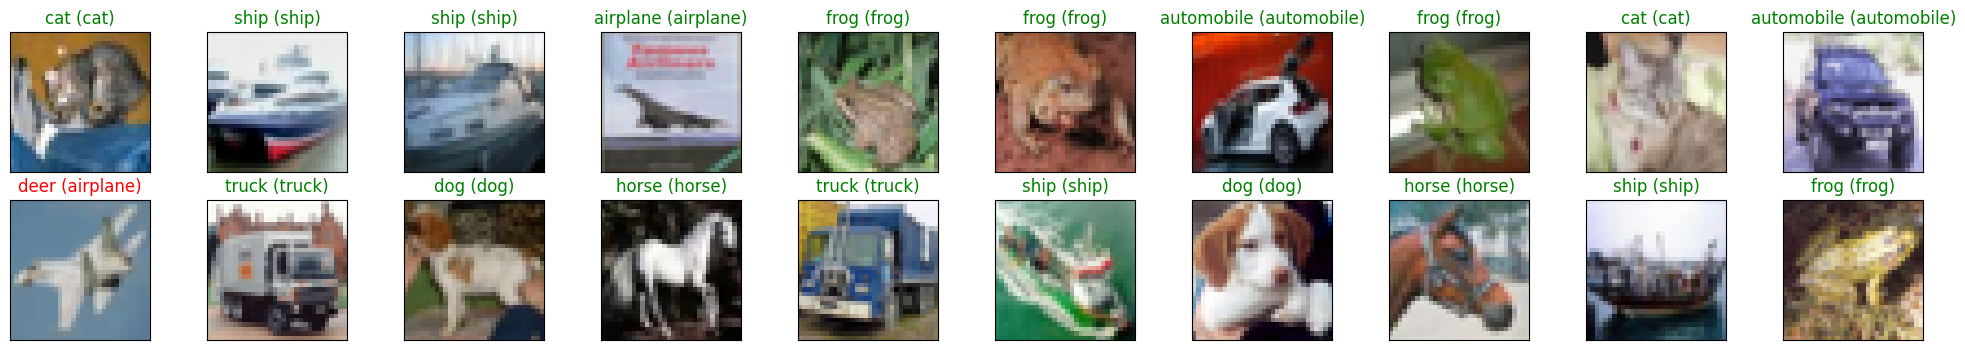

In [20]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))